# Agent interaction analysis
## Step by step data extraction

In [55]:
# Imports
import pandas as pd
# from egg.core.interaction import Interaction
import torch
from sklearn.decomposition import PCA
from pathlib import Path
from matplotlib import pyplot as plt

In [43]:
# Path to your interaction file
import os
path_to_interaction = Path("/Users/u203445/Documents/projects/EGG/")
inter = torch.load(path_to_interaction / "cont_interactions_2")


In [46]:
cont_messages = torch.cat([a for a in inter.message])
print("mean = ",cont_messages.mean().item())
print("standard deviation = ",cont_messages.std().item())


mean =  0.4151911735534668
standard deviation =  0.2668488621711731


In [47]:
def interaction_to_dataframe(interaction):
    """
    Function to turn the Interaction file into a pandas DataFrame which is covered with syntaxic sugar so easy to use
    """
    df = pd.DataFrame()
    # skipped as is empty in the emecom_pop case
    # df["sender_input"] = interaction.sender_input
    # df["receiver_input"] = interaction.receiver_input
    df["labels"] = interaction.labels
    for key in interaction.aux_input:
        if key == "receiver_message_embedding": # in continuous format message and receiver embedding are the same
            for dim, value in enumerate(interaction.message.T):
                df[f"dim_{dim}"] = value
        else:
            df[key] = interaction.aux_input[key]
    df["receiver_output"] = [i.argmax().item() for i in interaction.receiver_output]

    return df

In [48]:
df_inter = interaction_to_dataframe(inter)
# quick overview of what the dataframe looks like
# the function .sample(10) randomly selects 10 elements from the DataFrame
print(df_inter.sample(3))

       labels  sender_idx  recv_idx  loss_idx  batch_number     dim_0  \
12278      14           0         2         0          2294  0.095989   
20482      84           1         0         0           514  0.114567   
59301      83           2         3         0          4389  0.157427   

          dim_1     dim_2     dim_3     dim_4  ...     dim_7     dim_8  \
12278  0.661471  0.332269  0.392943  0.794768  ...  0.567984  0.928934   
20482  0.932886  0.050775  0.221579  0.423329  ...  0.192403  0.685483   
59301  0.785287  0.261378  0.093819  0.844775  ...  0.140718  0.412194   

          dim_9    dim_10    dim_11    dim_12    dim_13    dim_14    dim_15  \
12278  0.308655  0.193660  0.259015  0.080367  0.364631  0.288311  0.072099   
20482  0.495276  0.840021  0.255845  0.697303  0.763502  0.696768  0.375409   
59301  0.158912  0.151292  0.868583  0.853912  0.262215  0.581440  0.168792   

       receiver_output  
12278               54  
20482                2  
59301             

## PCA analysis example
lets make a 2 component PCA with the scikit-learn tool, to get a visual idea of clusters and their correspondance to the pretrained 'human' classes

In [161]:
# select which sender to analyse
# chosen_sender_index = [0,1,2,3]
chosen_sender_index = [2,3]
selectedsender_interactions = df_inter[df_inter.sender_idx.isin(chosen_sender_index)]

In [165]:
pca = PCA(n_components=2)
x = selectedsender_interactions.loc[:, selectedsender_interactions.columns.str.contains('dim')]
principalComponents = pca.fit_transform(x)
df_pca = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

# adding the labels for colouring purposes in plot
print(selectedsender_interactions.labels.shape,df_pca.shape)
df_pca['labels'] = selectedsender_interactions.labels.values
print(df_pca.sample(3))

(39936,) (39936, 2)
       principal component 1  principal component 2  labels
14246              -0.366984              -0.181564      99
24370               0.088247              -0.182925      99
34483              -0.372609               0.182495      62


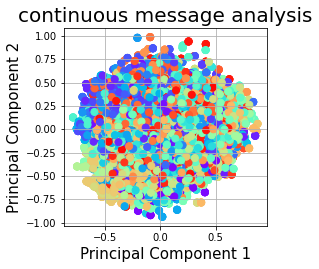

In [169]:
# plotting the PCA (and realising these dimensions ain't helping for clustering...)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('continuous message analysis', fontsize = 20)
colors = plt.cm.rainbow(torch.arange(0, 1, 0.01))

# here I´m colouring the different classes with different colours
ax.scatter(df_pca['principal component 1']
            , df_pca['principal component 2']
            , color = colors[df_pca['labels']]
            , s = 50)
ax.grid()